In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from us_states_abbrev import *

In [3]:
covid_path = "data/covid/us_states_covid19_daily.csv"
covid_all_path = "data/covid/us_covid19_daily.csv"
traffic_path = "data/traffic/US_Accidents_June20.csv"

covid_data = pd.read_csv(covid_path, usecols=['date', 'state', 'positive', 'negative', 'totalTestResults', 'hospitalizedCurrently', 'hospitalizedCumulative', 'death'])
covid_all_data = pd.read_csv(covid_all_path, usecols=['date', 'positive'])
traffic_data = pd.read_csv(traffic_path, usecols=['Start_Time', 'State'])
traffic_data = traffic_data.rename(columns={'State': 'state'})

In [4]:
population_path = 'data/population/nst-est2019-alldata.csv'
population_data = pd.read_csv(population_path, usecols=['NAME', 'POPESTIMATE2018', 'POPESTIMATE2019'])
population_data = population_data.rename(columns={'NAME': 'state', 'POPESTIMATE2018': 'population2018', 'POPESTIMATE2019': "population2019"})

In [5]:
#Convert state 2-letter code to full name
covid_data['state'] = covid_data['state'].map(abbrev_us_state)
traffic_data['state'] = traffic_data['state'].map(abbrev_us_state)

In [6]:
covid_unique = covid_data['state'].unique()
traffic_unique = traffic_data['state'].unique()


In [7]:
#Discovers the states that are included in the Covid dataset but not the traffic dataset
contains = False
difference = []
for covid_state in covid_unique:
    for traffic_state in traffic_unique:
        if covid_state == traffic_state:
            contains = True
    if(contains == False):
        difference.append(covid_state)
    contains = False



In [8]:
# Convert date column to datetime object
covid_data['date'] = pd.to_datetime(covid_data['date'], format='%Y%m%d')
traffic_data['date'] = pd.to_datetime(traffic_data['Start_Time'], format='%Y-%m-%d %H:%M:%S').dt.date
covid_all_data['date'] = pd.to_datetime(covid_all_data['date'], format='%Y%m%d')

# Remove Start_Time column from traffic_data
traffic_data = traffic_data[['date', 'state']]

In [9]:
def get_daily_covid_state(state):

    # Extract the covid data for the given state
    state_covid_data = covid_data.loc[covid_data['state'] == state]

    covid_cumulative = []

    # Iterate each covide positives in state
    for row in state_covid_data['positive']:
        covid_cumulative.insert(0, row)

    covid_none_cumulative = []
    
    covid_none_cumulative.append(covid_cumulative[0])
    for i in range(1, len(covid_cumulative)):
        new_cases = covid_cumulative[i] - covid_cumulative[i-1]
        covid_none_cumulative.append(new_cases)

    covid_none_cumulative.reverse()

    return covid_none_cumulative


In [10]:
def get_daily_covid_contry():

    covid_all = covid_all_data

    covid_cumulative = []

    # Iterate each covide positives
    for row in covid_all['positive']:
        covid_cumulative.insert(0, row)

    covid_none_cumulative = []

    covid_none_cumulative.append(covid_cumulative[0])
    for i in range(1, len(covid_cumulative)):
        new_cases = covid_cumulative[i] - covid_cumulative[i-1]
        covid_none_cumulative.append(new_cases)

    covid_none_cumulative.reverse()

    return covid_none_cumulative

print(get_daily_covid_contry())

[35289, 47733, 55526, 43772, 38567, 49439, 39472, 36295, 45539, 47486, 43558, 40021, 35445, 33864, 34453, 42087, 44927, 37581, 30983, 22223, 28682, 33117, 44905, 51591, 44714, 30603, 42433, 31406, 39501, 44501, 46548, 43984, 44053, 36379, 34643, 37566, 46236, 46561, 43758, 44955, 40795, 37880, 42487, 56149, 55636, 51759, 56134, 55701, 42089, 50627, 53712, 61345, 54187, 52324, 51866, 49713, 46812, 61101, 67623, 69418, 64408, 59003, 55332, 61000, 64741, 75236, 71552, 69333, 63930, 57041, 64260, 64951, 76842, 71036, 65797, 62729, 58091, 61312, 62895, 66846, 59157, 62672, 51728, 41918, 45612, 54338, 53948, 54085, 50981, 47864, 39813, 41570, 43164, 44543, 39640, 39072, 33447, 27281, 27928, 32294, 31471, 27746, 24001, 23497, 18630, 21399, 25376, 23597, 22153, 20894, 17312, 17209, 18740, 23064, 23400, 20880, 20392, 20110, 20482, 21558, 23682, 23574, 22630, 19437, 16830, 18691, 20047, 21531, 24447, 26674, 21318, 20899, 21016, 20034, 24678, 24684, 26798, 21272, 22897, 18371, 21063, 25218, 27217

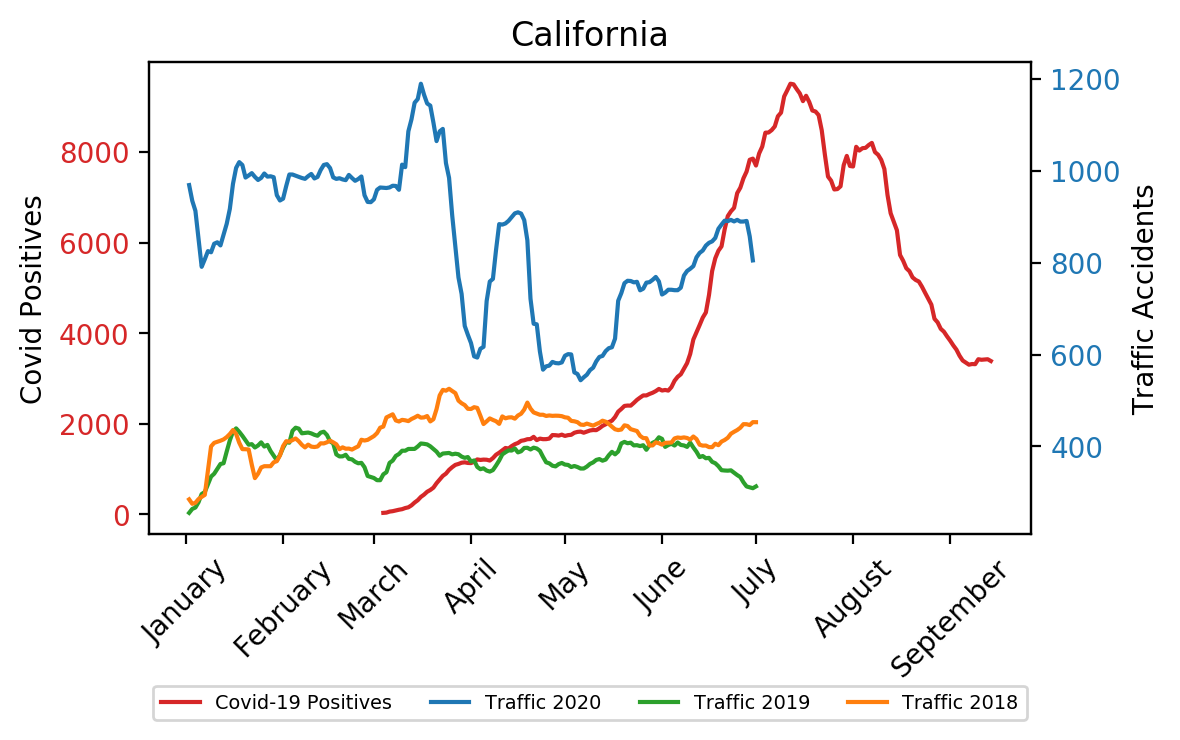

In [19]:
import datetime
def plot_covid_state(state, moving_avg_window):

    # Extract the covid data for the given state
    state_covid_data = covid_data.loc[covid_data['state'] == state]

    # Extract the traffic data for the given state
    state_traffic_data = traffic_data.loc[traffic_data['state'] == state]

    state_population = population_data.loc[population_data['state'] == state]

    # Merge rows with same date and add a counter column
    # TODO: Make sure this is done correctly
    state_traffic_data['count'] = state_traffic_data.groupby(['date'])['date'].transform('size')
    state_traffic_data.drop_duplicates(keep='first', inplace=True)
    state_traffic_data = state_traffic_data.sort_values(by='date')

    #Calculate ratio of accidents against state population
    population_2019 = state_population.iloc[0]['population2019']
    state_traffic_data['ratio'] = state_traffic_data['count'] / population_2019

    # Apply moving average to data
    state_traffic_data['count'] = state_traffic_data['count'].rolling(window = moving_avg_window).mean()

    # Traffic data 2020 to June
    start_date = pd.to_datetime('2020-01-01', format='%Y-%m-%d', errors='ignore')
    end_date = pd.to_datetime('2021-01-01', format='%Y-%m-%d', errors='ignore')
    mask = (state_traffic_data['date'] > start_date) & (state_traffic_data['date'] <= end_date)
    state_traffic_data_2020 = state_traffic_data.loc[mask]

    # Traffic data 2019 to June
    start_date = pd.to_datetime('2019-01-01', format='%Y-%m-%d', errors='ignore')
    end_date = pd.to_datetime('2019-07-01', format='%Y-%m-%d', errors='ignore')
    mask = (state_traffic_data['date'] > start_date) & (state_traffic_data['date'] <= end_date)
    state_traffic_data_2019 = state_traffic_data.loc[mask]
    state_traffic_data_2019['date'] = state_traffic_data_2019['date'] + pd.DateOffset(years=1)
    
    # Traffic data 2018 to June
    start_date = pd.to_datetime('2018-01-01', format='%Y-%m-%d', errors='ignore')
    end_date = pd.to_datetime('2018-07-01', format='%Y-%m-%d', errors='ignore')
    mask = (state_traffic_data['date'] > start_date) & (state_traffic_data['date'] <= end_date)
    state_traffic_data_2018 = state_traffic_data.loc[mask]
    state_traffic_data_2018['date'] = state_traffic_data_2018['date'] + pd.DateOffset(years=2)


    fig, ax1 = plt.subplots(dpi = 100, linewidth=0.6)
    plt.xticks(rotation = 45)

    # Plot covid cases
    dates_covid = state_covid_data['date']
    #positives = state_covid_data['positive']
    positives = get_daily_covid_state(state)
    positives = pd.Series(positives)
    positives = positives.rolling(window = moving_avg_window).mean()

    color = 'tab:red'
    ax1.set_ylabel('Covid Positives')
    line1 = ax1.plot(dates_covid, positives, color=color, label='Covid-19 Positives')
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx() # Instantiate a second axes that shares the same x-axis

    # Plot traffic accidents 2020
    dates_traffic = state_traffic_data_2020['date']
    accidents = state_traffic_data_2020['count']

    color = 'tab:blue'
    ax2.set_ylabel('Traffic Accidents')
    line2 = ax2.plot(dates_traffic, accidents, color=color, label='Traffic 2020')

    # Plot traffic accidents 2019
    dates_traffic = state_traffic_data_2019['date']
    accidents = state_traffic_data_2019['count']

    color = 'tab:green'
    line3 = ax2.plot(dates_traffic, accidents, color=color, label='Traffic 2019')

    # Plot taffic accidents 2018
    dates_traffic = state_traffic_data_2018['date']
    accidents = state_traffic_data_2018['count']

    color = 'tab:orange'
    line4 = ax2.plot(dates_traffic, accidents, color=color, label='Traffic 2018')
    
    ax2.set_xticklabels(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November'])

    ax2.tick_params(axis='y', labelcolor='tab:blue')

    # Combine labels from both axes
    lines = line1 + line2 + line3 + line4
    labels = [l.get_label() for l in lines]

    # Add legend to plot
    ax2.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0.30),
          ncol=4, fancybox=True, fontsize="x-small")

    # Set title
    plt.title(state)

    # Save figure
    fig.tight_layout()
    plt.savefig('figures/'+ state)
    
    # Show figure
    plt.show()

plot_covid_state('California', 14)

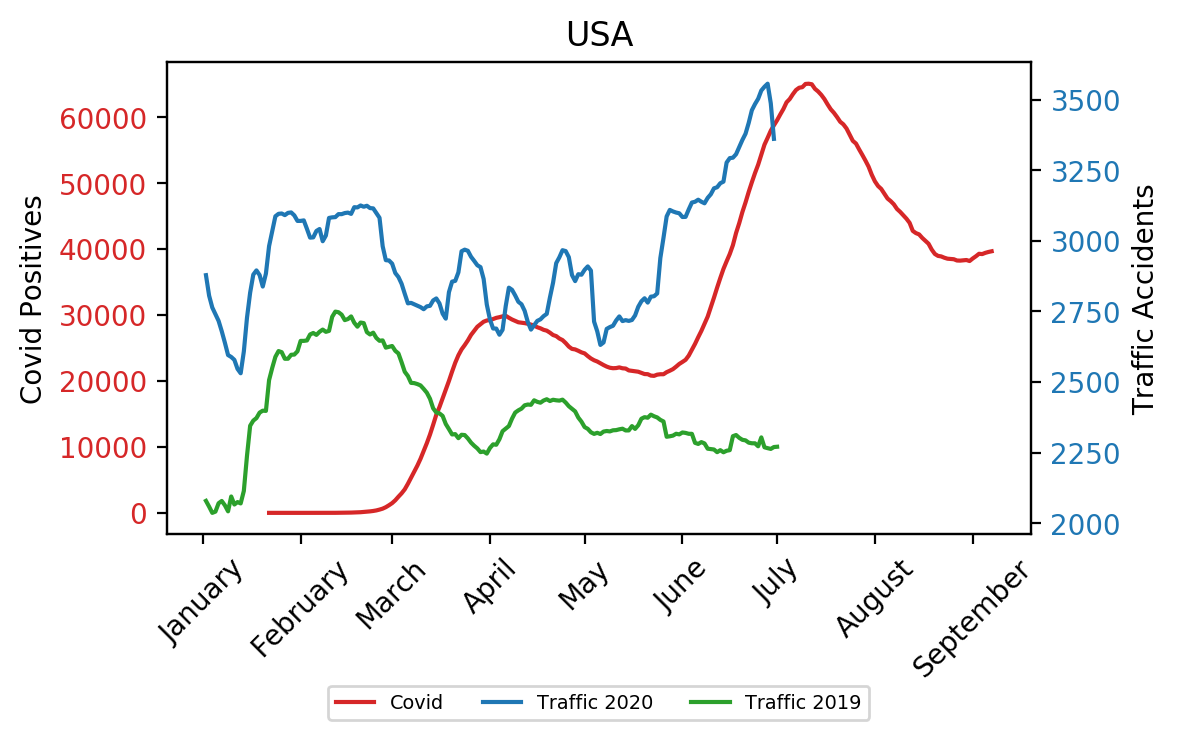

In [21]:
def plot_covid_country(moving_avg_window):

    covid_all = covid_all_data

    all_traffic_data = traffic_data.copy()
    all_traffic_data = all_traffic_data[['date']]

    # Merge rows with the same date and add a counter column
    all_traffic_data['count'] = all_traffic_data.groupby(['date'])['date'].transform('size')
    all_traffic_data.drop_duplicates(keep='first', inplace=True)
    all_traffic_data = all_traffic_data.sort_values(by='date')
    
    # Apply moving average to traffic data
    all_traffic_data['count'] = all_traffic_data['count'].rolling(window = moving_avg_window).mean()

    # Traffic data 2020 to June
    start_date = pd.to_datetime('2020-01-01', format='%Y-%m-%d', errors='ignore')
    end_date = pd.to_datetime('2021-01-01', format='%Y-%m-%d', errors='ignore')
    mask = (all_traffic_data['date'] > start_date) & (all_traffic_data['date'] <= end_date)
    all_traffic_data_2020 = all_traffic_data.loc[mask]

    # Traffic data 2019 to June
    start_date = pd.to_datetime('2019-01-01', format='%Y-%m-%d', errors='ignore')
    end_date = pd.to_datetime('2019-07-01', format='%Y-%m-%d', errors='ignore')
    mask = (all_traffic_data['date'] > start_date) & (all_traffic_data['date'] <= end_date)
    all_traffic_data_2019 = all_traffic_data.loc[mask]
    all_traffic_data_2019['date'] = all_traffic_data_2019['date'] + pd.DateOffset(years=1)

    fig, ax1 = plt.subplots(dpi = 100, linewidth=0.6)
    plt.xticks(rotation = 45)

    # Plot covid cases
    dates_covid = covid_all['date']
    positives = covid_all['positive']
    positives = get_daily_covid_contry()
    positives = pd.Series(positives)
    positives = positives.rolling(window = moving_avg_window).mean()

    color = 'tab:red'
    ax1.set_ylabel('Covid Positives')
    line1 = ax1.plot(dates_covid, positives, color=color, label="Covid")
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx() # Instantiate a second axes that shares the same x-axis

    # Plot traffic accidents 2020
    dates_traffic = all_traffic_data_2020['date']
    accidents = all_traffic_data_2020['count']

    color = 'tab:blue'
    ax2.set_ylabel('Traffic Accidents')
    line2 = ax2.plot(dates_traffic, accidents, color=color, label="Traffic 2020")
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_xticklabels(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November'])

    # Plot traffic accidents 2019
    dates_traffic = all_traffic_data_2019['date']
    accidents = all_traffic_data_2019['count']

    color = 'tab:green'
    line3 = ax2.plot(dates_traffic, accidents, color=color, label="Traffic 2019")

    # Combine labels from both axes
    lines = line1 + line2 + line3
    labels = [l.get_label() for l in lines]

    # Add legend to plot
    ax2.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0.30),
          ncol=4, fancybox=True, fontsize="x-small")

    plt.title('USA')

    # Show figure
    fig.tight_layout()
    plt.savefig('figures/USA')
    plt.show()

plot_covid_country(21)


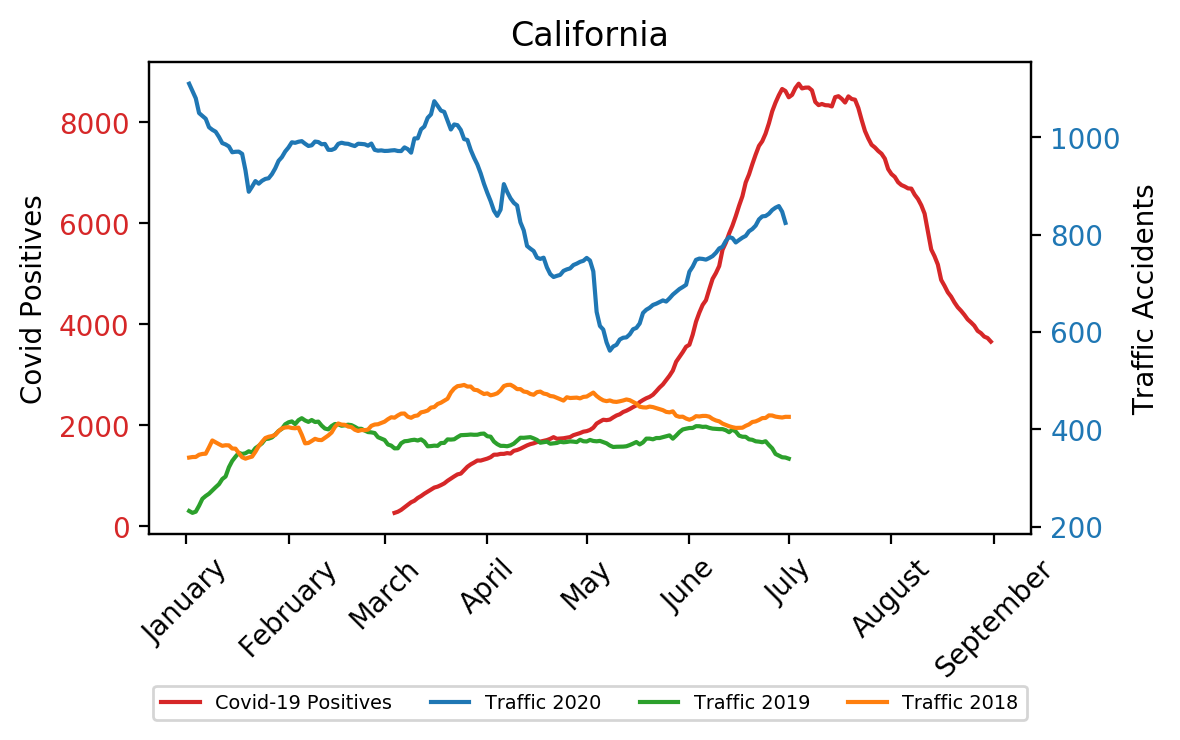

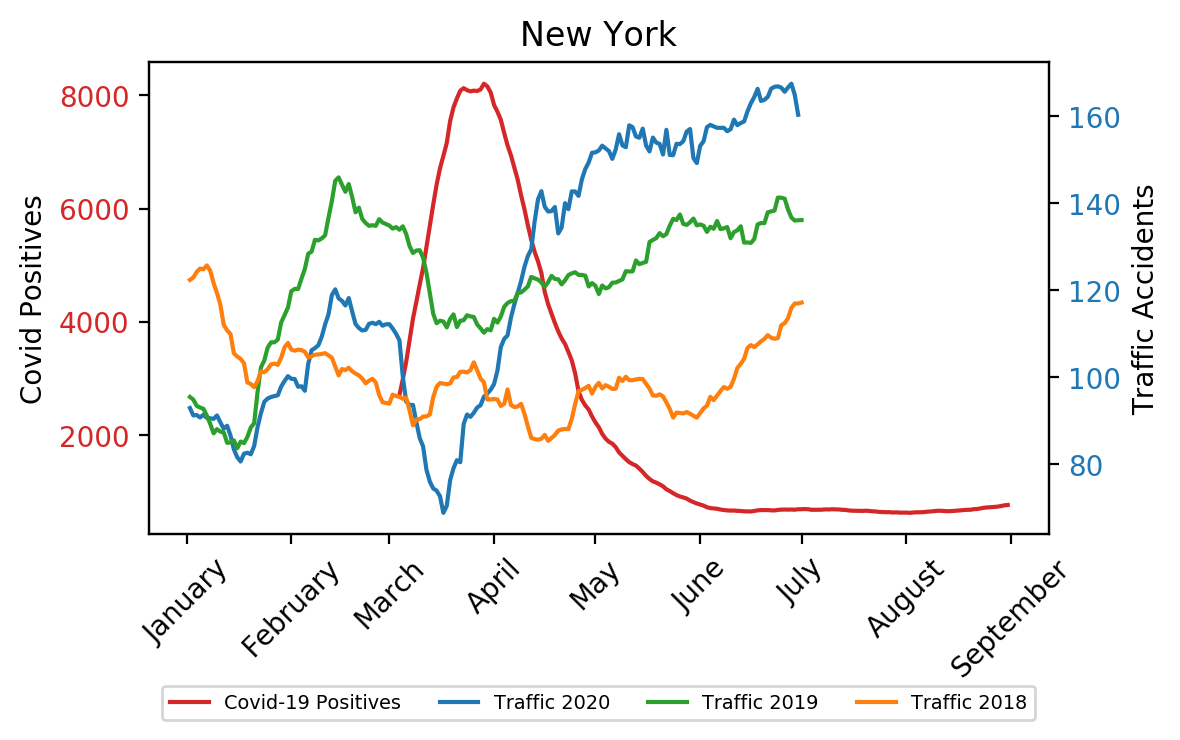

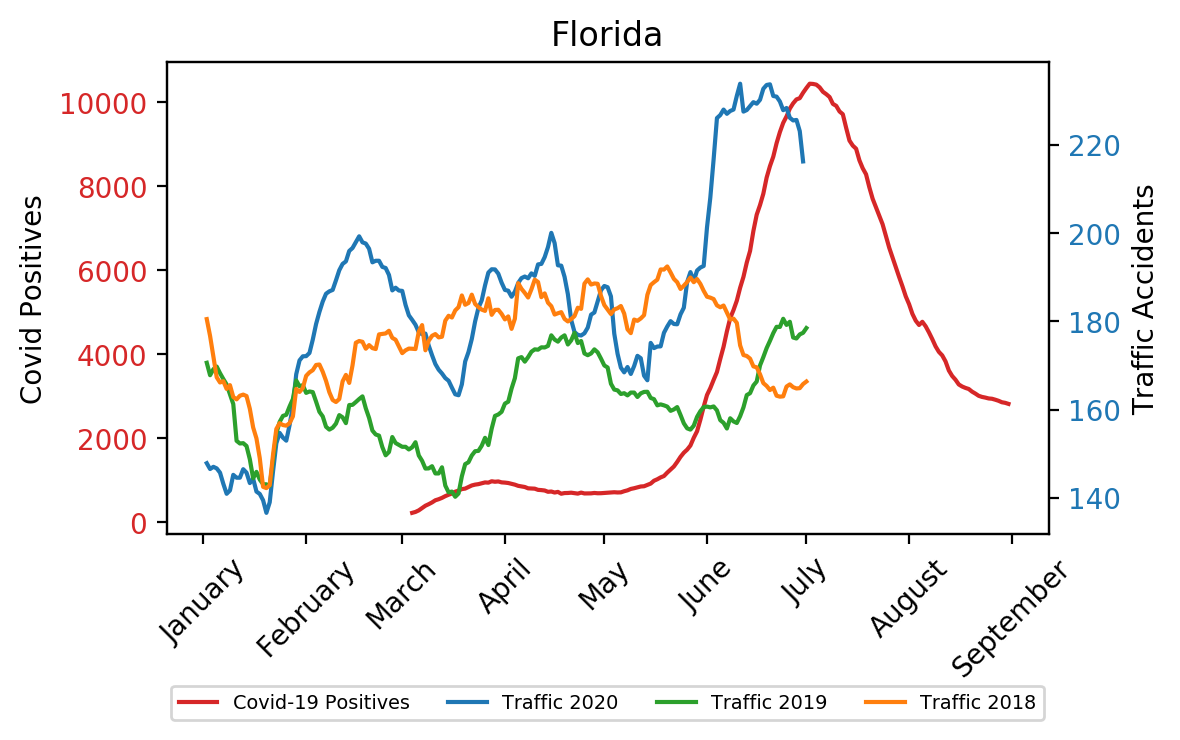

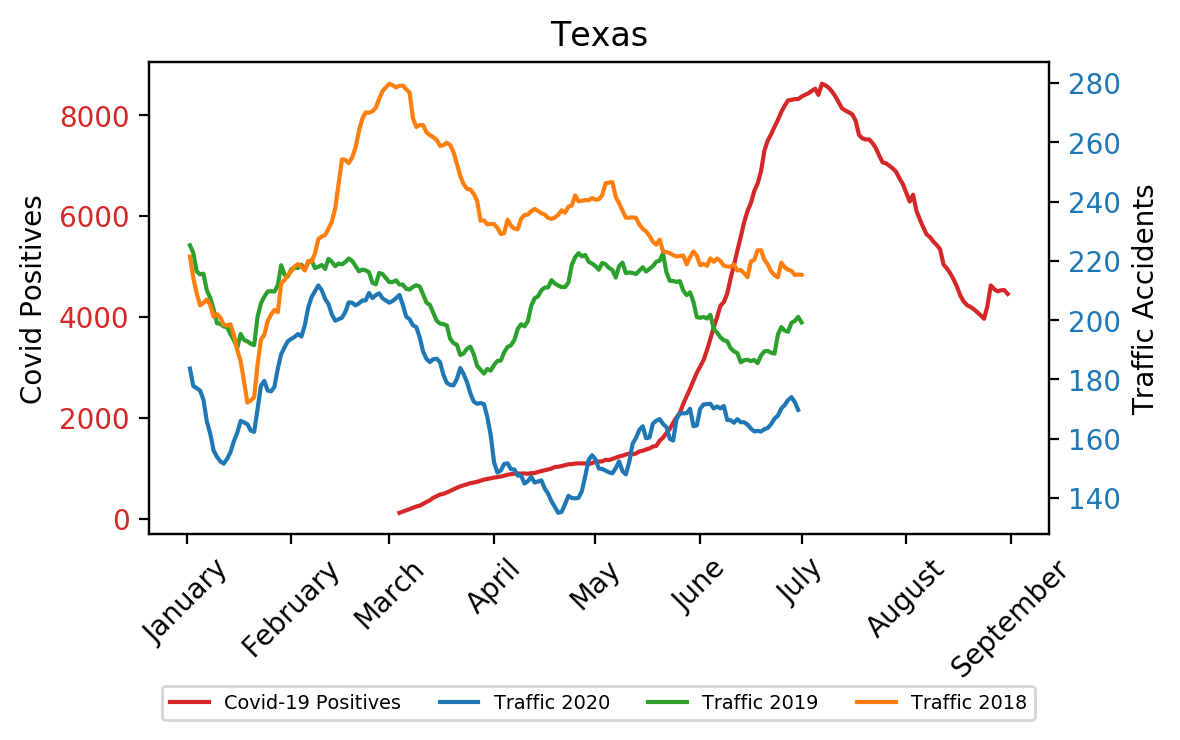

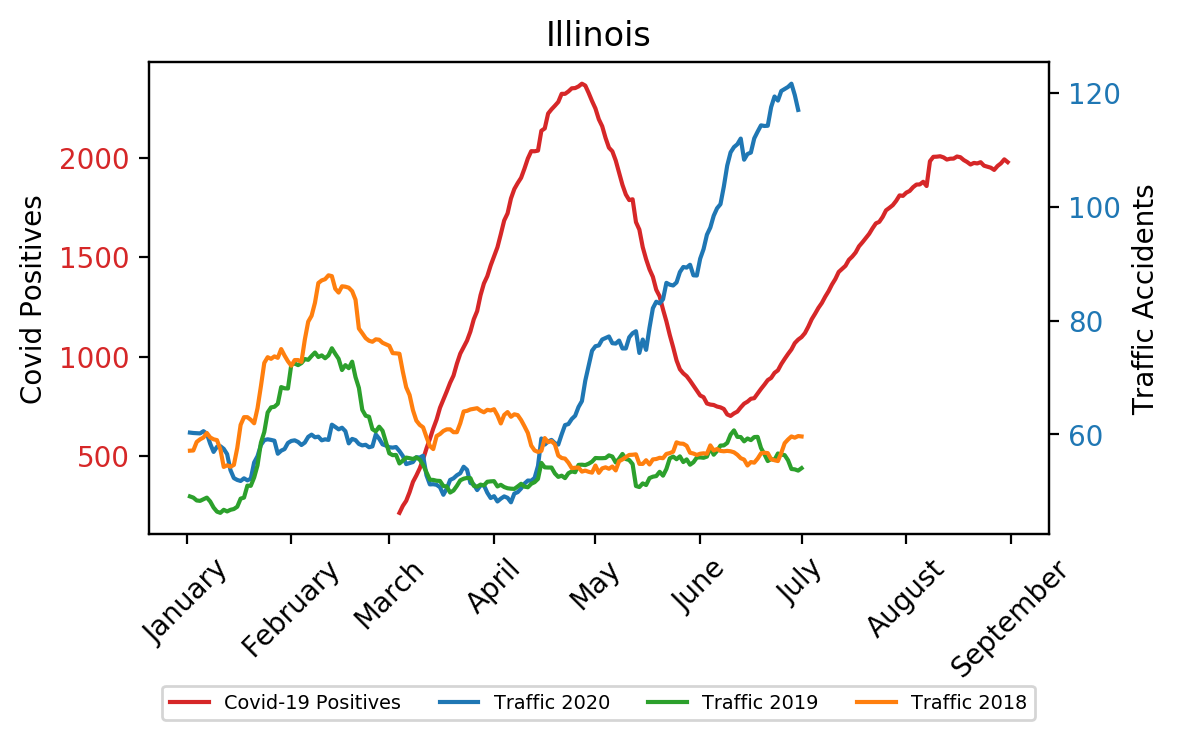

In [25]:
plot_covid_state('California', 28)
plot_covid_state('New York', 28)
plot_covid_state('Florida', 28)
plot_covid_state('Texas', 28)
plot_covid_state('Illinois', 28)
